In [1]:
import ROOT

Module libc not found.


Welcome to JupyROOT 6.30/09


In [2]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists

import read_config_utils as cu

In [4]:
import sys
import time

import gc

import pickle

import os.path


In [5]:


input_dir = 'output-run-nn-study-nd-v0c-ndim4'

input_dir = 'output-run-kde-study-1d-v0a'




points_file = 'mc-and-true-samples.npy'





In [6]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [7]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [8]:
with open( '%s/config-pars.pkl' % input_dir, 'rb') as f :
    mc_mu = pickle.load(f)
    mc_rho = pickle.load(f)
    mc_sig = pickle.load(f)
    true_mu = pickle.load(f)
    true_rho = pickle.load(f)
    true_sig = pickle.load(f)
    resolution = pickle.load(f)
    mc_cov = pickle.load(f)
    true_cov = pickle.load(f)

In [9]:
with open('%s/%s' % (input_dir, points_file),'rb') as f :
    mc_pts = np.load(f)
    mc_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)


In [10]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 333 bootstrap samples.




## Read in the main OmniFold ouput for the fake data and fit it before doing the bootstraps

In [11]:
fname = '%s/omnifold-output-weights.npy' % (input_dir)
#fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, 0)  

print('\n\n Reading in %s for weights in test fit.\n\n' % fname)
with open(fname,'rb') as f :
    sample_weights = np.load(f)



 Reading in output-run-kde-study-1d-v0a/omnifold-output-weights.npy for weights in test fit.




In [12]:

nmcevts = len(mc_pts)

print( "mc_pts shape:  %s" % str(mc_pts.shape))
print( "weights:  %s" % str(sample_weights.shape))

print( "number of MC events: %d" % nmcevts)

mc_pts shape:  (100000, 1)
weights:  (100000,)
number of MC events: 100000


In [13]:


true_cov  = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
   

   0,  0 : diagonal    0.8100


## Read in the simple calculation results to set the parameter limits

In [14]:
if not os.path.isfile( '%s/simple-calc-results.npy' % input_dir ) :
    
    print('\n\n **** no simple-calc-results.npy file.  Run inspect-output notebook, then rerun this.\n\n')
    sys.exit()
    

In [15]:
with open( '%s/simple-calc-results.npy' % input_dir, 'rb') as f :
    sc_ave_mean_val = np.load(f, allow_pickle=True )
    sc_ave_mean_rms = np.load(f, allow_pickle=True)
    sc_ave_cov_val  = np.load(f, allow_pickle=True)    
    sc_ave_cov_rms  = np.load(f, allow_pickle=True )



In [16]:
sc_ave_cov_val

array([[0.80581403]])

In [17]:
print('\n\n')
print('  Simple direct calculation results from the bootstrap samples.\n')

for fi in range(ndim) :
    print('  feature %d  mean:   %8.4f  (true %8.4f) RMS  %8.4f'
         % (fi, sc_ave_mean_val[fi], true_mu[fi], sc_ave_mean_rms[fi]) )
    
print('\n')

for i in range(ndim) :
    for j in range(i,ndim) :
        print('   %d, %d  cov:   %8.4f  (true %8.4f) RMS  %8.4f'
              % ( i, j, sc_ave_cov_val[i][j], true_cov[i,j], sc_ave_cov_rms[i][j]) )

print('\n\n')




  Simple direct calculation results from the bootstrap samples.

  feature 0  mean:     0.1984  (true   0.2000) RMS    0.0095


   0, 0  cov:     0.8058  (true   0.8100) RMS    0.0139





In [18]:
width_factor_mean = 10
width_factor_cov = 10

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [19]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = sc_ave_cov_val[i][j]
        minval = sc_ave_cov_val[i][j] - width_factor_cov * sc_ave_cov_rms[i][j]
        maxval = sc_ave_cov_val[i][j] + width_factor_cov * sc_ave_cov_rms[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            ######covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], 0.02, 2.0 )           
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            ######covdict[vname] =   ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], -1.1, 1.1 ) 
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        


 parameter cov00  min   0.6670, max   0.9446
RooRealVar::cov00 = 0.805814  L(0.667047 - 0.944581) 


In [20]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [21]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.806


### The Dict keeps the variables defined in memory

In [22]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = sc_ave_mean_val[i]
    minval = sc_ave_mean_val[i] - width_factor_mean * sc_ave_mean_rms[i]
    maxval = sc_ave_mean_val[i] + width_factor_mean * sc_ave_mean_rms[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    ##########muDict[vname] =  ROOT.RooRealVar( vname, vname, true_mu[i], -2., 2. )
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.1034, max   0.2933
RooRealVar::mu_x0 = 0.198367  L(0.10344 - 0.293294) 


In [23]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.805814
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8058 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |      1.241 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [24]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0


In [25]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))
ROOT.SetOwnership( data_test, True )

In [26]:
%%time

for i in range( len(sample_weights) ) :
    if i % (len(sample_weights)/100 ) == 0 : print( " %9d / %9d  (%6.0f)%%" % (i, len(sample_weights), 100*i/len(sample_weights)))
    for j in range( ndim ) :
        xVec[j].setVal( mc_pts[i,j] )
    weight.setVal( sample_weights[i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

         0 /    100000  (     0)%
      1000 /    100000  (     1)%
      2000 /    100000  (     2)%
      3000 /    100000  (     3)%
      4000 /    100000  (     4)%
      5000 /    100000  (     5)%
      6000 /    100000  (     6)%
      7000 /    100000  (     7)%
      8000 /    100000  (     8)%
      9000 /    100000  (     9)%
     10000 /    100000  (    10)%
     11000 /    100000  (    11)%
     12000 /    100000  (    12)%
     13000 /    100000  (    13)%
     14000 /    100000  (    14)%
     15000 /    100000  (    15)%
     16000 /    100000  (    16)%
     17000 /    100000  (    17)%
     18000 /    100000  (    18)%
     19000 /    100000  (    19)%
     20000 /    100000  (    20)%
     21000 /    100000  (    21)%
     22000 /    100000  (    22)%
     23000 /    100000  (    23)%
     24000 /    100000  (    24)%
     25000 /    100000  (    25)%
     26000 /    100000  (    26)%
     27000 /    100000  (    27)%
     28000 /    100000  (    28)%
     29000 /  

In [27]:
data_test

In [28]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 100000 entries
  Observables: 
    1)  x0 = -0.747556  L(-10 - 10)  "x0"
  Dataset variable "weight" is interpreted as the event weight


In [29]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = 1.62435


In [30]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        #########covRAL.find(vname).setConstant()

In [31]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.805814


In [32]:
covRAL.find("cov00").isConstant()

False

In [33]:
%%time

rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
ROOT.SetOwnership( rfr, True )


CPU times: user 121 ms, sys: 260 ms, total: 381 ms
Wall time: 846 ms
  copy constructor, Setting _prevCovVals[0] to 0.805814
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 28 remote server process.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 13108.8384625352228
Edm   = 2.92624950154534718e-05
Nfcn  = 36
cov00	  = 0.809038	 +/-  0.0114388	(limited)
mu_x0	  = 0.189132	 +/-  0.00898808	(limited)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       14187.23443 Edm =  -8.283617777e-08 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13109.36642
  Edm           : 0.5279686963
  Internal parameters:	[    0.02312040332  -1.46204663e-16]	
  Internal gradient  :	[    -0.0171190456      10.83652417]	
  Internal covariance matrix:
[[    0.013623857              0]
 [              0    0.017984043]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13109.36642
  Edm           : 0.5279686963
  Internal parameters:	[    0.02312040332  -1.46204663e-16]	
  Internal gradient  :	[    -0.0171190456      10.83652417]	
  Internal covariance matrix:
[[    0.013623857              0]
 [              0    0.017984043]]]
Info i

In [34]:
rfr.Print()


  RooFitResult: minimized FCN value: 13108.8, estimated distance to minimum: 2.92736e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 cov00    8.0904e-01 +/-  1.14e-02
                 mu_x0    1.8913e-01 +/-  8.99e-03



In [35]:
rfr.status()

0

In [36]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.809038 +/- 0.0114388


In [37]:
for i in range(ndim) :
    fit_mean = muDict["mu_x%d" % i].getVal()
    fit_mean_err = muDict["mu_x%d" % i].getError()
    print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
          (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

print("\n")

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        fit_cov = covdict["cov%d%d" % (i,j)].getVal()
        fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
        print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
               (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )

   0 :  mu =   0.1891   (true   0.2000) err   0.0090  diff  -0.0109   diff/err  -1.21


  0,  0 :  cov    0.8090  (true   0.8100) err   0.0114  diff  -0.0010   diff/err  -0.08


In [38]:

del data_test
del rfr
gc.collect()

0

In [39]:
n_samples = np.min( [n_samples,50] )

In [40]:
fit_results_mean_val = np.zeros( shape=(ndim, n_samples ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_samples ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_status = np.zeros( n_samples )

In [41]:
%%time

#### TESTING
###n_samples = 1

for bi in range( n_samples ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( mc_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print('Initializing values of fit parameters.')
    for i in range(ndim) :
        muDict["mu_x%d" % i].setVal( sc_ave_mean_val[i] )
        muDict["mu_x%d" % i].Print()
    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            covdict["cov%d%d" % (i,j)].setVal( sc_ave_cov_val[i,j] )
            covdict["cov%d%d" % (i,j)].Print()
    print('')
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    fit_status[bi] = rfr.status()
    
    print('\n Fit status: %d \n' % fit_status[bi])
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.1929   (true   0.2000) err   0.0089  diff  -0.0071   diff/err  -0.79


  0,  0 :  cov    0.8001  (true   0.8100) err   0.0113  diff  -0.0099   diff/err  -0.87

 Fit status: 0 

Cleaning up.


 --- bootstrap sample   1
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.2016   (true   0.2000) err   0.0090  diff   0.0016   diff/err   0.18


  0,  0 :  cov    0.8181  (true   0.8100) err   0.0115  diff   0.0081   diff/err   0.70

 Fit status: 0 

Cleaning up.


 --- bootstrap sample   2
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  R

Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.2006   (true   0.2000) err   0.0090  diff   0.0006   diff/err   0.07


  0,  0 :  cov    0.7998  (true   0.8100) err   0.0114  diff  -0.0102   diff/err  -0.90

 Fit status: 0 

Cleaning up.


 --- bootstrap sample  21
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-021.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.1915   (true   0.2000) err   0.0089  diff  -0.0085   diff/err  -0.95


  0,  0 :  cov    0.8045  (true   0.8100) err   0.0113  diff  -0.0055   diff/err  -0.49

 Fit status: 0 

Cleaning up.


 --- bootstrap sample  22
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-022.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.1852   (true   0.2000) err   0.0090  diff  -0.0148   diff/err  -1.64


  0,  0 :  cov    0.8090  (true   0.8100)

   0 :  mu =   0.1923   (true   0.2000) err   0.0088  diff  -0.0077   diff/err  -0.87


  0,  0 :  cov    0.7940  (true   0.8100) err   0.0111  diff  -0.0160   diff/err  -1.43

 Fit status: 0 

Cleaning up.


 --- bootstrap sample  41
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-041.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.1930   (true   0.2000) err   0.0090  diff  -0.0070   diff/err  -0.78


  0,  0 :  cov    0.8064  (true   0.8100) err   0.0114  diff  -0.0036   diff/err  -0.32

 Fit status: 0 

Cleaning up.


 --- bootstrap sample  42
Reading weights file : output-run-kde-study-1d-v0a/bootstrap-weights-042.npy
Filling RooDataSet with 100000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.1958   (true   0.2000) err   0.0089  diff  -0.0042   diff/err  -0.47


  0,  0 :  cov    0.7955  (true   0.8100) err   0.0112  diff  -0.0145   diff/err  -1.29

 Fit stat

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =         14150.188 Edm =  -9.666082711e-09 NCalls =      9
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13070.85986
  Edm           : 0.1847409832
  Internal parameters:	[   -0.04105151403  -1.46204663e-16]	
  Internal gradient  :	[   -0.02993740678      6.449797805]	
  Internal covariance matrix:
[[    0.013323741              0]
 [              0    0.017763315]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13070.85986
  Edm           : 0.1847409832
  Internal parameters:	[   -0.04105151403  -1.46204663e-16]	
  Internal gradient  :	[   -0.02993740678      6.449797805]	
  Internal covariance matrix:
[[    0.013323741              0]
 [              0    0.017763315]]]
Info i

In [42]:
with open( '%s/fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )
    np.save( f, fit_status )

<function matplotlib.pyplot.show(close=None, block=None)>

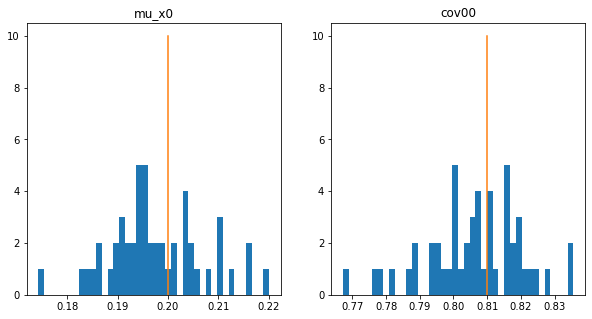

In [43]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_val[i,:], bins=hbins)
    thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_val[i,i,:], bins=hbins)
    thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

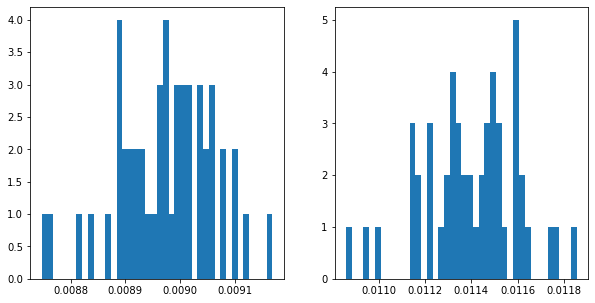

In [44]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_err[i,:], bins=hbins)
    #thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    #thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_err[i,i,:], bins=hbins)
    #thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    #thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

In [45]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')





  toy fits mu   ave. val   0.1976,  true  0.2000
  toy fits sig2 ave. val   0.8060,  true  0.8100



  toy fits mu   RMS:   0.0092,  ave fit err  0.0090
  toy fits sig2 RMS:   0.0141,  ave fit err  0.0114





In [46]:
fit_status

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])